In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media

from xmlMake import *
from Actuator import *
from optimization import *

from scipy.spatial.transform import Rotation as R

In [2]:
height = width = 1024
dt = 0.01

In [3]:
nDisks = 20
nSegments = 3

length = 0.1 * nSegments
radius = 0.05
fillRatio = 0.2
dx = length / ((nDisks + fillRatio - 1) * nSegments)

In [4]:
key = jax.random.PRNGKey(0)
params = 2 * jax.random.normal(key, (nSegments, 3))

optimizer = opt.adam(learning_rate=1e-2)
optState = optimizer.init(params)
criterion = jax.jit(jax.value_and_grad(l2Distance, 0))
pTarget = resampleUniform(CurveGenerator(nCtrl=3, order=2, nPoints=100, seed=400), 50)/2
p = resampleUniform(generateArcSpline(params, 1000), len(pTarget))
loss = []

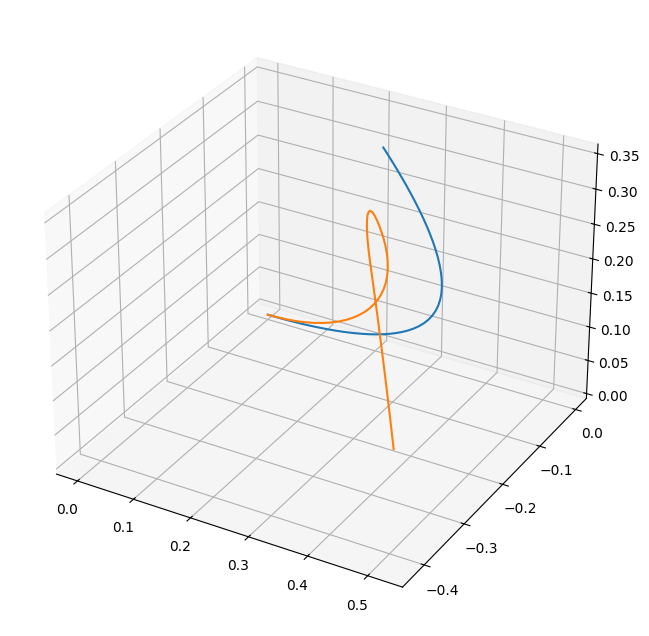

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pTarget[:,0], pTarget[:,1], pTarget[:,2])
ax.plot(p[:,0], p[:,1], p[:,2])

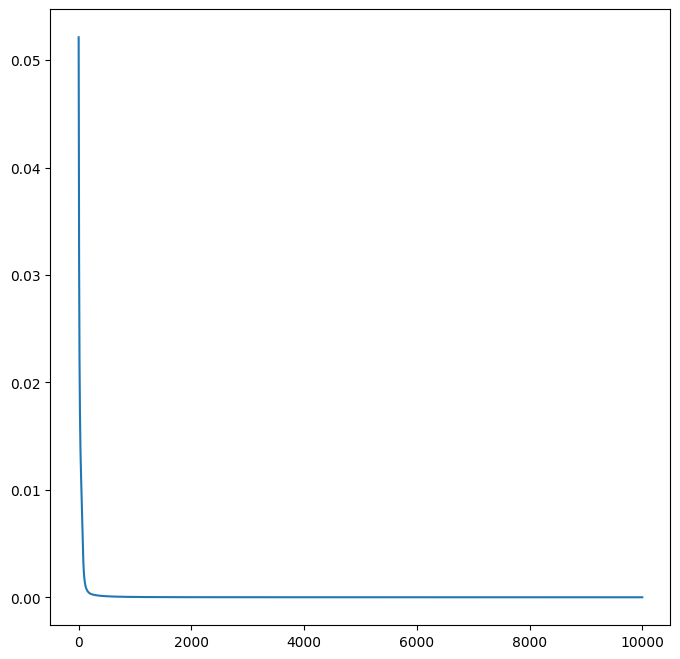

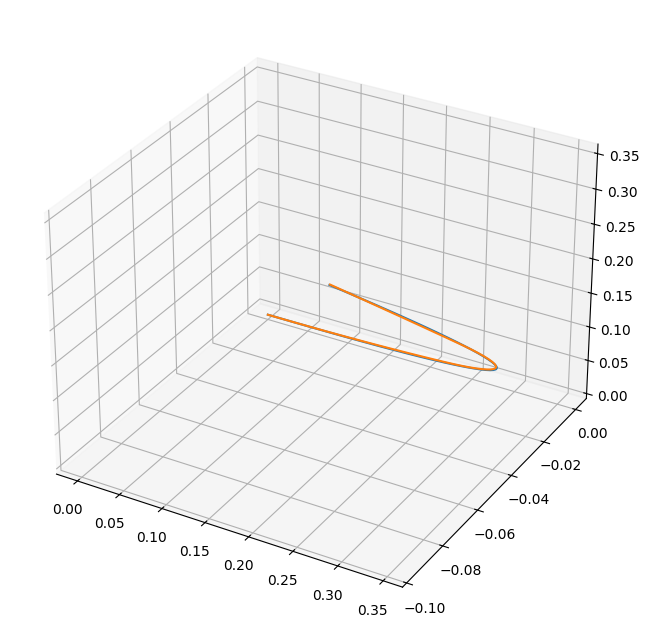

In [6]:
for ii in range(10000):
    L, params, optState = optimizationStep(params, pTarget, criterion, optimizer, optState)
    loss.append(L)
    print(f"Iteration {ii:06d}, Loss: {L:.6f}", end='\r', flush=True)

p = resampleUniform(generateArcSpline(params, 1000), len(pTarget))

fig = plt.figure(figsize=(8,8))
plt.plot(loss)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pTarget[:,0], pTarget[:,1], pTarget[:,2])
ax.plot(p[:,0], p[:,1], p[:,2])

In [7]:
innerStiffness = 0
innerDamping = 10

outerStiffness = 25
outerDamping = 3

force = 10

""

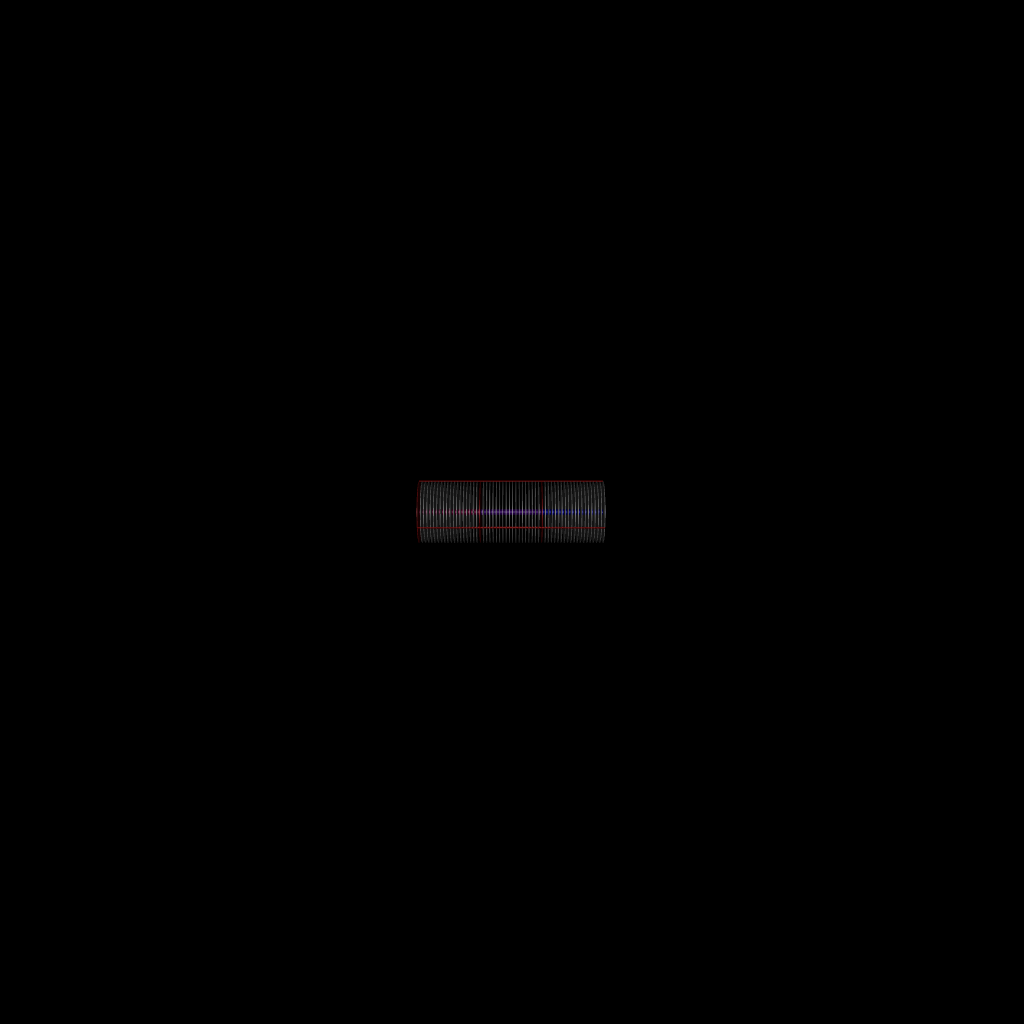

In [8]:
actuator3 = softActuator(nSegments= nSegments,
                         nDisks = nDisks,
                         length = length,
                         radius = radius,
                         innerStiffness = innerStiffness,
                         innerDamping = innerDamping,
                         outerStiffness = outerStiffness,
                         outerDamping = outerDamping,
                         gear = force,
                         mass = 0.1,
                         timeStep = dt,
                         fillRatio=fillRatio)
with mujoco.Renderer(actuator3.model, height, width) as renderer:
    renderer.update_scene(actuator3.data, camera='mainCamera')
    imRef = renderer.render()
media.show_image(imRef)

In [9]:
params_ = np.array((maxValue - minValue) * jnp.tanh(params) / 2 + (maxValue + minValue) / 2)
params_[:, -1] = np.cumsum(params_[:, -1])
percentage = np.zeros((nSegments, 3))
for ii in range(nSegments):
    percentage[ii] = calculateStiffness(params_[ii], dx, dx, dx, dx, innerStiffness, force, nDisks, radius)/outerStiffness

In [10]:
params_

array([[0.23362106, 0.26467264, 1.8213074 ],
       [0.24239933, 1.554792  , 1.8381956 ],
       [0.16308463, 0.32866687, 8.064635  ]], dtype=float32)

In [11]:
percentage

array([[0.96657792, 1.09362097, 0.92511982],
       [0.81257136, 1.95386487, 0.67280069],
       [1.97346925, 2.74964637, 1.74690747]])

In [12]:
duration = 10 # (seconds)
framerate = 60  # (fps)


# Simulate and display video.
frames = []
ii = 0
actuator3.reset()
for kk in range(nSegments):
    for jj in range(3):
        actuator3.setStiffness(kk, jj, percentage[kk, jj])
with mujoco.Renderer(actuator3.model, height, width) as renderer:
    while np.round(actuator3.data.time, 1-int(np.log10(dt))) <= duration:
        actuator3.step(1)
        if len(frames) < actuator3.data.time * framerate:
            renderer.update_scene(actuator3.data, camera='mainCamera')
            frame = renderer.render()
            frames.append(frame)
        ii += 1

In [13]:
media.show_video(frames, fps=framerate)

In [14]:
p_ = actuator3.data.site_xpos.reshape(-1, 4, 3)[:, 0]

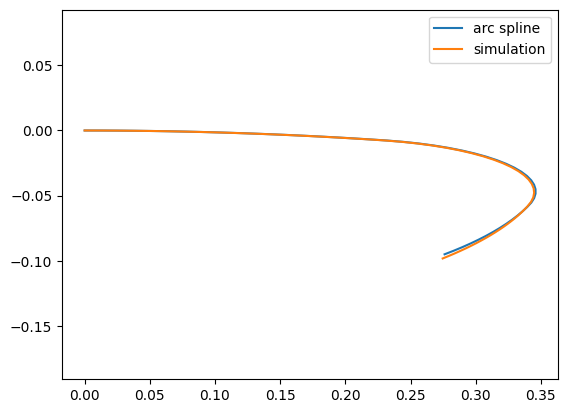

In [15]:
plt.axis('equal')
plt.plot(p[:,0], p[:,1], label='arc spline')
plt.plot(p_[:,0], p_[:,1], label='simulation')
plt.legend()
plt.show()

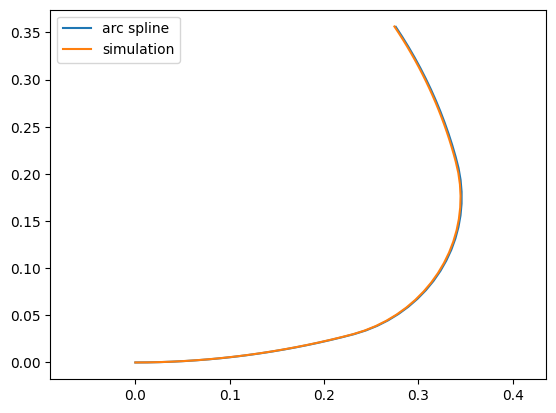

In [16]:
plt.axis('equal')
plt.plot(p[:,0], p[:,2], label='arc spline')
plt.plot(p_[:,0], p_[:,2], label='simulation')
plt.legend()
plt.show()

In [20]:
def set_axes_equal(ax):
    """
    Make x, y, z axes of a 3-D plot have the same scale
    so a unit cube looks like a cube.
    """
    # current limits
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    rng   = np.array([xlim, ylim, zlim])
    mids  = rng.mean(axis=1)
    radius = 0.5 * np.max(rng[:,1] - rng[:,0])

    ax.set_xlim3d(mids[0] - radius, mids[0] + radius)
    ax.set_ylim3d(mids[1] - radius, mids[1] + radius)
    ax.set_zlim3d(mids[2] - radius, mids[2] + radius)

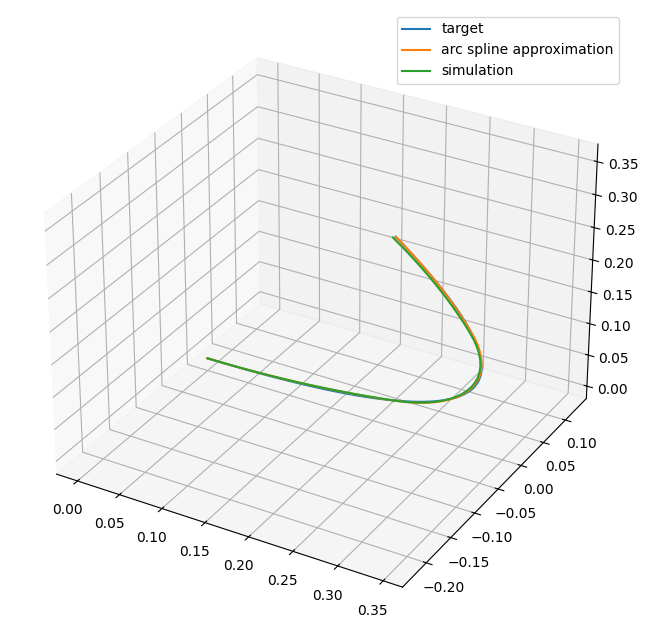

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pTarget[:,0], pTarget[:,1], pTarget[:,2], label='target')
ax.plot(p[:,0], p[:,1], p[:,2], label='arc spline approximation')
ax.plot(p_[:,0], p_[:,1], p_[:,2], label='simulation')
set_axes_equal(ax)
ax.legend()
plt.show()